In [20]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt

# SHAPER
from pyshaper.CommonObservables import buildCommmonObservables
from pyshaper.Observables import Observable
from pyshaper.Shaper import Shaper

# Utils
from utils import load_cmsopendata
from pyshaper.utils.plot_utils import plot_event


# Necessary GPU nonsense
import torch 

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 

Using CPU!


Max # of particles: 77
(125, 2)
[0.00845846 0.00845846 0.00845846 ... 0.00845846 0.00845846 0.00845846]


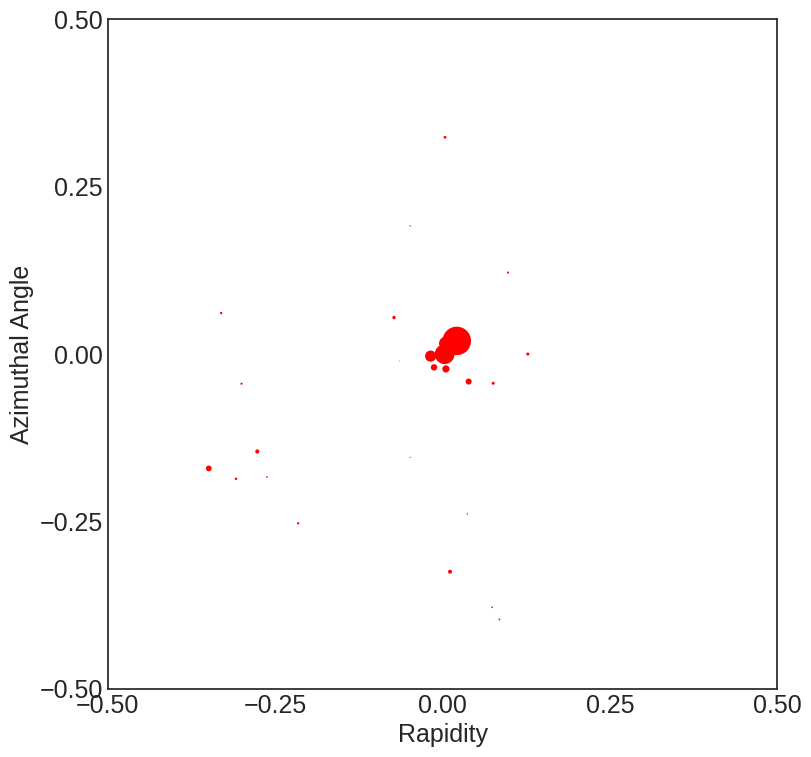

<Axes: xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [21]:
# Build 3 particle events
R = 1.0
N = 180
angles = np.linspace(0, np.pi, N)

events = []
for i in range(N):

    zs = np.array([4.0/6.0, 1.0/6.0, 1.0/6.0])
    points = np.array([
                        (0.0, 0.0),
                        (R, 0.0),
                        (R*np.cos(angles[i]), R*np.sin(angles[i]))
              ])
    events.append((points, zs))

In [22]:
# TODO: my SHAPER representation of events is somewhat inefficient. do over.
def compute_spectral_representation(events, pad = 125, omega_max = 2, type = "event", dtype = np.float32):

    # events shape is (batch_size, pad, 3)
    points, zs = events[:,:,1:], events[:,:,0]
    batch_size = zs.shape[0]
    euclidean_distance_squared = np.sum(np.square(points[:,:, None, :] - points[:,None, :, :]), axis=-1)
    

    # Upper Triangle Matrices
    if type == "event":
        omega_ij = np.triu(euclidean_distance_squared / 2)
    elif type == "jet":
        omega_ij = np.triu(np.sqrt(euclidean_distance_squared ))
    triangle_indices = np.triu_indices(pad, k = 1)

    ee_ij = np.triu(zs[:,:,None] * zs[:,None,:])
    ee2 = np.trace(ee_ij, axis1 = 1, axis2=2)

    # Flatten to 1D Spectral Representation and remove 0s
    omega_n = omega_ij[:,triangle_indices[0], triangle_indices[1]]
    ee_n = 2 * ee_ij[:,triangle_indices[0], triangle_indices[1]]
    mask = omega_n > 0


    s = np.stack((omega_n, ee_n), axis = 1)
    s = np.transpose(s, (0,2,1))
    print(s.shape)

    
    # Sort and append 0
    indices = s[:,:,0].argsort()
    temp_indices = np.arange(batch_size)[:,np.newaxis]
    s = s[temp_indices,indices]
    s0 = np.zeros((batch_size, 1, 2))
    s0[:,0,1] = ee2
    s = np.concatenate((s0, s), axis = 1)

    return s.astype(dtype)


s = compute_spectral_representation(dataset, pad = pad, type = "jet")

(10, 2775, 2)


2775.0
(2776, 2)


/tmp/ipykernel_18172/355314625.py:13: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 1)


(0.0013995078097018875, 1)

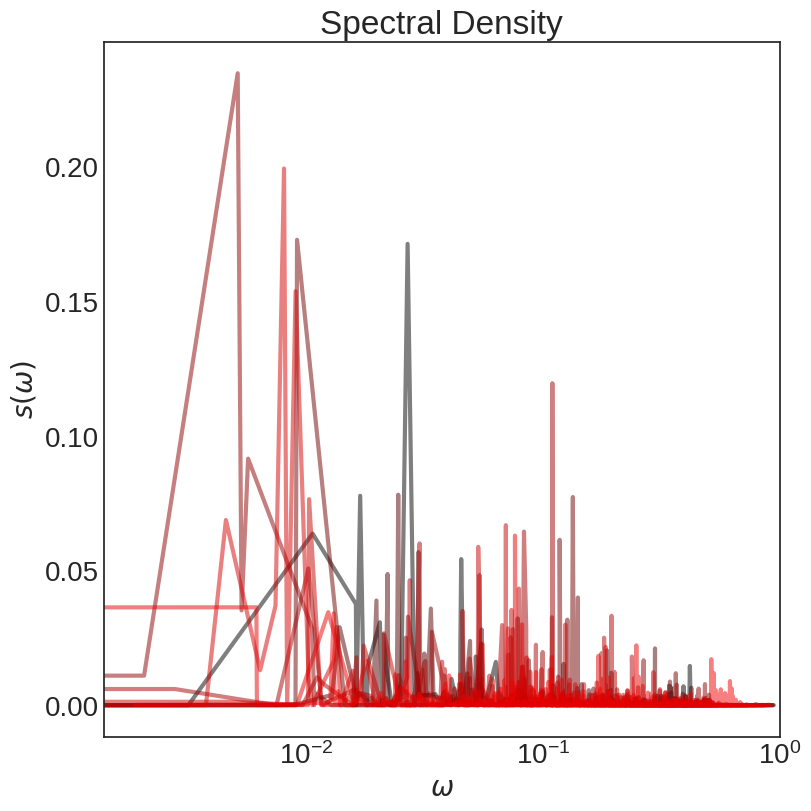

In [23]:
# Weird plot
print(75 * (75-1)/2)
print(s[0].shape)

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))
for (i,event) in enumerate(dataset):
    plt.plot(s[i,1:,0], s[i,1:,1], color = (np.sqrt(i/len(dataset)),0,0), alpha = 0.5, lw = 3)
plt.xscale("log")
plt.title("Spectral Density")
plt.ylabel("$s(\omega)$")
plt.xlabel("$\omega$")
plt.xlim(0, 1)

In [24]:
def weighted_sum(s, p = 2, max_index = None, inclusive = True):
    
    if max_index is None:
        return np.sum(s[:,:,1] * np.power(s[:,:,0], p), axis = -1)
    else:
        max_index = max_index + 1 if inclusive else max_index
        return np.sum(s[:,:max_index,1] * np.power(s[:,:max_index,0], p),axis = -1)


# def energy_sum(s, max_index = None, inclusive = True):
#     if max_index is None:
#         return np.sum(s[:,1])
#     else:
#         max_index = max_index + 1 if inclusive else max_index
#         return np.sum(s[:max_index,1] )


def cross_term(s1, s2, pairwise = True):

    # Input Parsing
    if pairwise == False:
        raise NotImplementedError("Pairwise sEMDs not implemented!")
    batch_size_1 = s1.shape[0]
    batch_size_2 = s2.shape[0]
    if batch_size_2 != batch_size_1 and pairwise == True:
        raise ValueError("Must have equal batch sizes for line-by-line sEMDs! Found batch sizes of {batch_size_1} and {batch_size_2}!Z")

    # Cross term
    omega1s = s1[:,:,0]
    omega2s = s2[:,:,0]

    E1s = s1[:,:,1]
    E2s = s2[:,:,1]


    E1_cumsums = np.cumsum(E1s, axis = -1)
    E2_cumsums = np.cumsum(E2s, axis = -1)
    shifted_E1_cumsums = np.concatenate((E1_cumsums[:,0][:,None], E1_cumsums[:,:-1]), axis = -1) 
    shifted_E2_cumsums = np.concatenate((E2_cumsums[:,0][:,None], E2_cumsums[:,:-1]), axis = -1) 

    
    
    omega_n_omega_l = omega1s[:,:,None] * omega2s[:,None,:]
    minE = np.minimum(E1_cumsums[:,:,None], E2_cumsums[:,None,:])
    maxE = np.maximum(shifted_E1_cumsums[:,:,None], shifted_E2_cumsums[:,None,:])
    x = minE - maxE

    cross = omega_n_omega_l * x * theta(x)
    cross_term = np.sum(cross, axis = (-1,-2))

    print(np.count_nonzero(cross[0]))

    plt.contourf((omega_n_omega_l * x * theta(x))[0])
    return cross_term

def theta(x):

    return x > 0 


def ds2(s1, s2, pairwise = False):

    if pairwise == True:
        raise NotImplementedError("Pairwise sEMDs not implemented!")
    batch_size_1 = s1.shape[0]
    batch_size_2 = s2.shape[0]
    if batch_size_2 != batch_size_1 and pairwise == False:
        raise ValueError("Must have equal batch sizes for line-by-line sEMDs! Found batch sizes of {batch_size_1} and {batch_size_2}!Z")


    term1 = weighted_sum(s1)
    term2 = weighted_sum(s2)
    print(term1.shape, term2.shape)

    return term1 + term2 - 2*cross_term(s1, s2)




def theta_terms(s1, s2, pairwise = True):

    # Input Parsing
    if pairwise == False:
        raise NotImplementedError("Pairwise sEMDs not implemented!")
    batch_size_1 = s1.shape[0]
    batch_size_2 = s2.shape[0]
    if batch_size_2 != batch_size_1 and pairwise == True:
        raise ValueError("Must have equal batch sizes for line-by-line sEMDs! Found batch sizes of {batch_size_1} and {batch_size_2}!Z")

    # Cross term
    omega1s = s1[:,:,0]
    omega2s = s2[:,:,0]

    E1s = s1[:,:,1]
    E2s = s2[:,:,1]


    E1_cumsums = np.cumsum(E1s, axis = -1)
    E2_cumsums = np.cumsum(E2s, axis = -1)
    shifted_E1_cumsums = np.concatenate((E1_cumsums[:,0][:,None], E1_cumsums[:,:-1]), axis = -1) 
    shifted_E2_cumsums = np.concatenate((E2_cumsums[:,0][:,None], E2_cumsums[:,:-1]), axis = -1) 

    
    
    omega_n_omega_l = omega1s[:,:,None] * omega2s[:,None,:]
    minE = np.minimum(E1_cumsums[:,:,None], E2_cumsums[:,None,:])
    maxE = np.maximum(shifted_E1_cumsums[:,:,None], shifted_E2_cumsums[:,None,:])
    x = minE - maxE

    print(omega_n_omega_l.size * omega_n_omega_l.itemsize * 1e-9)
    print(x.size * x.itemsize * 1e-9)
    print(theta(x).dtype, x.dtype, omega_n_omega_l.dtype)
    print(theta(x).size * theta(x).itemsize * 1e-9)

    cross = omega_n_omega_l * x * theta(x)
    cross_term = np.sum(cross, axis = (-1,-2))

    zeros, indices = np.count_nonzero(cross, axis = (-1, -2)), np.nonzero(cross)
    return zeros, indices




1.38711168
1.38711168
bool float32 float32
0.34677792
(45,) (45,)
1169


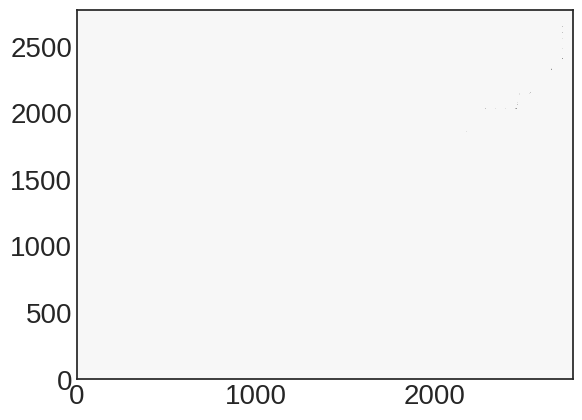

In [25]:
i, j = np.tril_indices(N, k = -1)
s1 = s[i]
s2 = s[j]
zeros, indices = theta_terms(s1, s2)

sEMDs = ds2(s1, s2)

(array([30.,  4.,  3.,  0.,  1.,  2.,  1.,  2.,  0.,  2.]),
 array([0.00054195, 0.00920027, 0.01785858, 0.0265169 , 0.03517522,
        0.04383354, 0.05249185, 0.06115017, 0.06980849, 0.0784668 ,
        0.08712512]),
 <BarContainer object of 10 artists>)

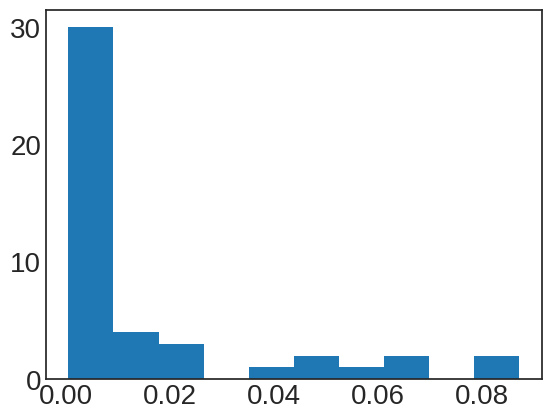

In [26]:
plt.hist(sEMDs)

In [27]:
event_id, row1, row2 = zip(indices)
print(row1[0], row2[0])
print(row1[0] - row2[0])

[ 596  597  598 ... 2775 2775 2775] [1177 1177 1177 ... 2719 2720 2721]
[-581 -580 -579 ...   56   55   54]


In [28]:
pad_sizes = [1, 5, 10, 25, 50, 75]

xs = []
ys = []

for pad in pad_sizes:

    dataset, sim_weights = load_cmsopendata("~/.energyflow/", "cms", pt_lower, pt_upper, eta, quality, pad, n = 10)
    s = compute_spectral_representation(dataset, pad = pad, type = "jet")

    i, j = np.tril_indices(N, k = -1)
    s1 = s[i]
    s2 = s[j]

    zs = theta_terms(s1, s2)
    for (i, z) in enumerate(zs):
        xs.append(pad)
        ys.append(z)



Max # of particles: 77
(10, 0, 2)
1.8000000000000002e-07
1.8000000000000002e-07
bool float32 float32
4.5000000000000006e-08
Max # of particles: 77
(10, 10, 2)
2.178e-05
2.178e-05
bool float32 float32
5.445e-06
Max # of particles: 77
(10, 45, 2)
0.00038088
0.00038088
bool float32 float32
9.522e-05
Max # of particles: 77
(10, 300, 2)
0.016308180000000002
0.016308180000000002
bool float32 float32
0.0040770450000000005
Max # of particles: 77
(10, 1225, 2)
0.27055368
0.27055368
bool float32 float32
0.06763842
Max # of particles: 77
(10, 2775, 2)
1.38711168
1.38711168
bool float32 float32
0.34677792


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


ValueError: setting an array element with a sequence.

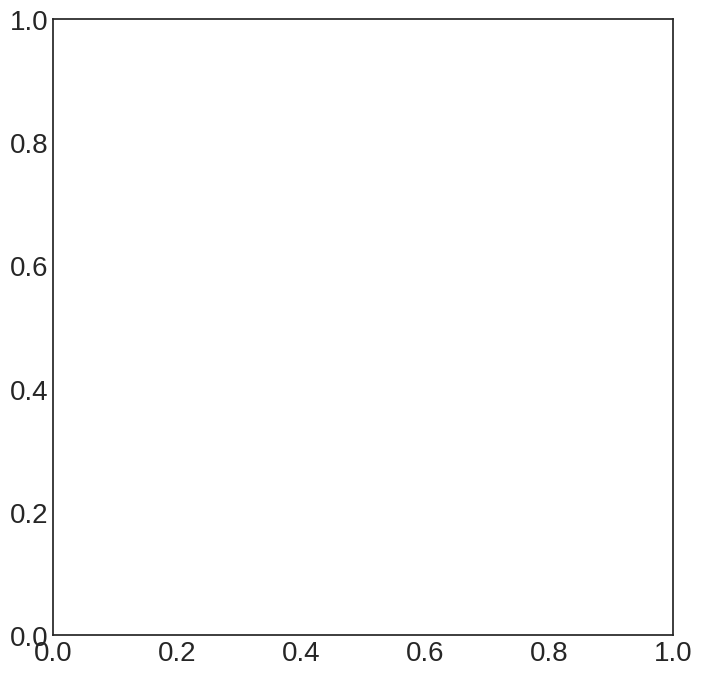

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))

x_line = np.linspace(0, 100, 1000)
plt.scatter(xs, ys, label = "Nonzero terms")
plt.plot(x_line, x_line**2, color = "green", label = "N^2")
plt.plot(x_line, x_line**4, color = "orange", label = "N^4")
plt.legend()

plt.yscale("log")
plt.xscale("log")
plt.xlabel("# Particles (N)")
plt.ylabel("# Terms")
plt.xlim(1, 100)



In [ ]:
def f(x):
    return x**2

grad(f)